<a href="https://colab.research.google.com/github/VolkhinD/Animals/blob/main/Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage.io import imread
from torch.utils.data import DataLoader,Dataset, random_split
from tqdm.notebook import tqdm
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Download data

I did this work for [Kaggle Dataset](https://www.kaggle.com/datasets/anshulmehtakaggl/wildlife-animals-images) 'Wild Animals'. So there are 2 ways of getting data and creating Torch Dataset in

*   Kaggle Notebook
*   Google Colab Notebook

In Kaggle notebook, challenge is to choose only one type of photo in 3 types. 
Since I want to use only 300*300 photos, I added a new condition to find_classes method in DatasetFolder, parent of ImageFolder. [Source ](https://github.com/pytorch/vision/blob/651b97e2d0ebb1594ba5a318a6df69cb5129588a/torchvision/datasets/folder.py#L108)

In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transforms = transforms.Compose([                            
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

# class AnimalData(ImageFolder):
        
#     def find_classes(self, directory):
#         """Finds the class folders in a dataset.
#         See :class:`DatasetFolder` for details.
#         """
#         classes = sorted(entry.name for entry in os.scandir(directory) if
#                          entry.is_dir() and '-resize-300' in entry.name)
        
#         class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
#         return classes, class_to_idx        
    
# def cracked(name):
#     return '244_300resized' not in name and '224_300resized' not in name

# dataset = AnimalData('../input/wildlife-animals-images', transform=data_transforms, is_valid_file=cracked)
# class_names = dataset.classes
# print(' | '.join(class_names))
# print(len(dataset))
# train_len = int(0.8*len(dataset))
# test_len = len(dataset) - train_len
# train, test = random_split(dataset, [train_len, test_len],
#                            generator=torch.Generator().manual_seed(42))
# datasets = {'train': train, 'test': test}
# train_dataloader =  DataLoader(train, batch_size=8, shuffle=True) 
# test_dataloader = DataLoader(test, batch_size=8, shuffle=True)
# dataloaders =  {x: DataLoader(datasets[x], batch_size=4, shuffle=True) for x in ['train', 'test']}
# dataset_sizes = {'train': train_len, 'test': test_len}

In [6]:
data_dir = '/content/drive/MyDrive/Data/Animal'

dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

class_names = dataset.classes
print(class_names)
print(len(dataset))
train_len = int(0.8*len(dataset))
test_len = len(dataset) - train_len
print(f'Train size is {train_len}, Test size is {test_len}')
train, test = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(4))

train_dataloader =  DataLoader(train, batch_size=8, shuffle=True) 
test_dataloader = DataLoader(test, batch_size=8, shuffle=True)
dataloaders = {'train': train_dataloader, 'test': test_dataloader}
dataset_sizes = {'train': train_len, 'test': test_len}                                                                             

['cheetah', 'fox', 'hyena', 'lion.', 'tiger', 'wolf']
1723
Train size is 1378, Test size is 345


In [7]:
def count_classes():
  count_classes = {i: 0 for i in class_names}
  for i in range(len(dataset)):
    if dataset[i][1] == 0:
      count_classes['cheetah'] += 1
    elif dataset[i][1] == 1:
      count_classes['fox'] += 1
    elif dataset[i][1] == 2:
      count_classes['hyena'] += 1
    elif dataset[i][1] == 3:
      count_classes['lion.'] += 1
    elif dataset[i][1] == 4:
      count_classes['tiger'] += 1
    elif dataset[i][1] == 5:
      count_classes['wolf'] += 1
  
  return count_classes



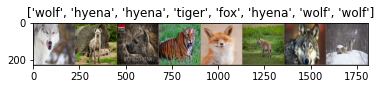

In [8]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


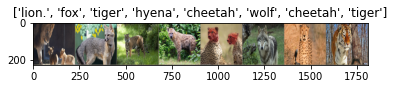

In [9]:
# Get a batch of test data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Useful Functions

In [10]:
def test_model(model):
    model.eval()

    running_corrects = 0

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
     
            running_corrects += torch.sum(preds == targets.data)

    
    acc = running_corrects.double()/test_len
    return round(acc.item(), 5)

def train_model(model, criterion, optimizer, schedular, num_epoch=3):

    since = time.time()
    list_of_loss = []
    model.train()
    for epoch in tqdm(range(num_epoch)):

        print(f'Current epoch is {epoch + 1}/{num_epoch}')
        curr_loss = 0
        epoch_loss = 0

        for inputs, labels in train_dataloader:
    
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item() * inputs.size(0)
    
            
        if schedular != None:
            schedular.step()
        epoch_loss = curr_loss/train_len
        print(f'Loss is {epoch_loss}')
        list_of_loss.append(epoch_loss)
  

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return list_of_loss

def set_seed(n):
    random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    
def set_model(n):
    set_seed(n)
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 6)
    model = model.to(device)
    
    return model
    

# Models

I use same pretrained Resnet18 model. Each time I change optimizer and schedular. 

## 1 Approach:
Train a whole model with constant learning rate

In [11]:
model_1 = set_model(42)
optimizer_1 = optim.Adam(model_1.parameters(), lr = 0.01)
criterion_1 = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
test_model(model_1)

0.15072

In [ ]:
train_model(model_1, criterion_1, optimizer_1, schedular = None)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.5078913604478043
Current epoch is 2/3
Loss is 0.4206522090568515
Current epoch is 3/3
Loss is 0.3775174709998415
Training complete in 6m 38s


[0.5078913604478043, 0.4206522090568515, 0.3775174709998415]

In [ ]:
test_model(model_1)

0.97971

## 2 Approach:
Train a model with [Step_lr](http://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR) shcedular, so every N steps learning rate is multiplied by gamma. [MultiStepLR ](http://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR)also might be used where learning rate changes once the number of epoch reaches one of the milestones. 

In [ ]:
model_2 = set_model(42)
optimizer_2 = optim.Adam(model_2.parameters(), lr = 0.01)
criterion_2 = nn.CrossEntropyLoss()
lr_schedular_2 = lr_scheduler.StepLR(optimizer_2, step_size=2, gamma=0.1) # every 2 steps decrease lr by 10 times

In [ ]:
test_model(model_2)

0.10145

In [ ]:
train_model(model_2, criterion_2, optimizer_2, lr_schedular_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.49155834477586763
Current epoch is 2/3
Loss is 0.49609688633314775
Current epoch is 3/3
Loss is 0.18895435353623877
Training complete in 6m 27s


[0.49155834477586763, 0.49609688633314775, 0.18895435353623877]

In [ ]:
test_model(model_2)

0.98551

## 3 Approach
Set different learning rates for diferent layers. Or Layer-Wise Learning Rate. The key idea is to gradually reduce the learning rate when going deeper into the network.



In [ ]:
model_3 = set_model(42)

list_of_layers = []
for layer in model_3.named_parameters():
    list_of_layers.append(layer[0])
list_of_layers.reverse()
lr = 0.01  
parameters = []
prev_group_name = list_of_layers[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(list_of_layers):
    
    cur_group_name = name.split('.')[0]
    
    # update learning rate
    if cur_group_name != prev_group_name:
        lr *= 0.8
    prev_group_name = cur_group_name
    
    
    #print(f'lr = {lr:.4f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model_3.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

optimizer_3 = optim.Adam(parameters)
creterion_3 = nn.CrossEntropyLoss()



In [ ]:
train_model(model_3, creterion_3, optimizer_3, schedular = None)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.5078913604478043
Current epoch is 2/3
Loss is 0.4206522090568515
Current epoch is 3/3
Loss is 0.3775174709998415
Training complete in 6m 20s


[0.5078913604478043, 0.4206522090568515, 0.3775174709998415]

In [ ]:
test_model(model_3)

0.97101

## 4 Approach
Use any function to change learning rate. [Lambda Shcedular](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR)

In [ ]:
model_4 = set_model(42)
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=0.01)
lambda_4 = lambda epoch: 0.9 ** epoch
schedular_4 = lr_scheduler.LambdaLR(optimizer_4, lambda_4)
criterion_4 = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(5):

  optimizer_4.step()
  schedular_4.step()

  print(optimizer_4.state_dict()['param_groups'][0]['lr'])
  

0.009000000000000001
0.008100000000000001
0.007290000000000001
0.006561
0.005904900000000001


In [ ]:
train_model(model_4, criterion_2, optimizer_4, schedular_4)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.3981475929752619
Current epoch is 2/3
Loss is 0.2755038314211724
Current epoch is 3/3
Loss is 0.23682976925566462
Training complete in 6m 17s


[0.3981475929752619, 0.2755038314211724, 0.23682976925566462]

In [ ]:
test_model(model_4)

0.93913

# 5 Approach
[ReduceLRonPlateau ](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau). Reduce learning rate when a metric has stopped improving. This time schedular step should be called after validation step. 


In [ ]:
def train_model_with_test(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'test':
                scheduler.step(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 

In [ ]:
model_5 = set_model(42)
creterion_5 = nn.CrossEntropyLoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=0.01)
schedular_5 = lr_scheduler.ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=3) 
#patience is how long wait with no improvement (by defoult 10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
train_model_with_test(model_5, creterion_5, optimizer_5, schedular_5)

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4916 Acc: 0.8491
test Loss: 0.0870 Acc: 0.9826

Epoch 2/3
----------
train Loss: 0.3690 Acc: 0.9020
test Loss: 0.0988 Acc: 0.9681

Epoch 3/3
----------
train Loss: 0.3929 Acc: 0.9129
test Loss: 0.1396 Acc: 0.9797

Training complete in 16m 29s


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_model(model_5)

0.98261